In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [42]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
tf.config.list_physical_devices('GPU') 


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [9]:
from tensorflow import keras

In [24]:
PROJECT_PATH = '../'
SRBF_PATH = "/scratch/ceph/swei20/data/dnn/BHB/rbf_RedM_R5000_1k.h5"
TRAIN_PATH = '/scratch/ceph/swei20/data/dnn/BHB/bosz_1k.h5'
TEST_PATH = "/scratch/ceph/swei20/data/dnn/DNN_BHB_RedM_n3300.h5"
NORM_PATH = "/scratch/ceph/szalay/swei20//norm_flux.h5"
# NORM_PATH = "/scratch/ceph/dobos/data/pfsspec/import/stellar/rbf/bosz_5000_full/norm/spectra.h5"
sys.path.insert(0, PROJECT_PATH)

In [25]:
# def save_rbf(spvals, slogflux, snflux, spc, sv, wave, SAVE_RBF_PATH):
#     with h5py.File(SAVE_RBF_PATH, 'w') as f:
#         f.create_dataset('pc',   data = spc, shape=spc.shape)
#         f.create_dataset('logflux', data = slogflux, shape=slogflux.shape)
#         f.create_dataset('normflux', data = snflux, shape=snflux.shape)
#         f.create_dataset('eigv', data = sv, shape = sv.shape)
# #         f.create_dataset('eigs', data = rbf.grid.eigs['flux'], shape = rbf.grid.eigs['flux'].shape)
#         f.create_dataset('wave', data = wave, shape = wave.shape)
#         f.create_dataset('pval', data = spvals, shape=spvals.shape)
#         f.create_dataset("rbf_path", data = RBF_PATH)

In [26]:
with h5py.File(SRBF_PATH, 'r') as f:
    logflux = f['logflux'][()]
    normflux = f['normflux'][()]
    pc = f['pc'][()]
    wave = f['wave'][()]
    pval = f['pval'][()]
    #     eigv = f['eigv'][()]



In [27]:
logflux.shape, normflux.shape, pc.shape, wave.shape,pval.shape

((1000, 2204), (1000, 2204), (1000, 2000), (2204,), (1000, 5))

In [50]:
bndT = np.array([[-2.5, -1.5], [7000.0, 9500.0], [2.0, 3.0], [-0.75, 0.5], [-0.25, 0.5]]).T

In [52]:
pnorm=(pval -bndT[0])/(bndT[1]-bndT[0])

In [73]:
from dnn.model.dnn_model import DNN

In [74]:
x_train = pc
y_train = pnorm
d = DNN(input_dim=x_train.shape[1], hidden_dims=[2048, 512, 128, 32, 8], dp=0.0, lr=0.01)
d.build_model()

[2000, 2048, 512, 128, 32, 8, 5]


In [75]:
d.fit(x_train, y_train, ep=2)

Epoch 1/2
2/2 [==============================] - 1s 137ms/step - loss: 271.3664 - mean_squared_error: 271.3664 - val_loss: 2.7130 - val_mean_squared_error: 2.7130
Epoch 2/2
2/2 [==============================] - 0s 23ms/step - loss: 2.9376 - mean_squared_error: 2.9376 - val_loss: 4.2364 - val_mean_squared_error: 4.2364
1 {'_self_setattr_tracking': True, '_is_model_for_instrumentation': True, '_instrumented_keras_api': True, '_instrumented_keras_layer_class': False, '_instrumented_keras_model_class': True, '_trainable': True, '_stateful': False, 'built': True, '_input_spec': None, '_build_input_shape': TensorShape([None, 2000]), '_saved_model_inputs_spec': TensorSpec(shape=(None, 2000), dtype=tf.float32, name='input'), '_supports_masking': True, '_name': 'dnn', '_activity_regularizer': None, '_trainable_weights': [], '_non_trainable_weights': [], '_updates': [], '_thread_local': <_thread._local object at 0x7f2ec4051860>, '_callable_losses': [], '_losses': [], '_metrics': [], '_metrics_l

In [61]:
from tensorflow.keras.callbacks import Callback as cb

In [62]:
cb

tensorflow.python.keras.callbacks.Callback

### Load data

In [67]:
with h5py.File(TRAIN_PATH, 'r') as f:
    train_x = f['flux'][()]
    train_y= f['para_norm'][()]
    pcp = f['pcp'][()]
    para = f["para"][()]

In [27]:
train_x.shape

(100000, 20)

In [28]:
with h5py.File(TEST_PATH, 'r') as f:
    test_x = f['flux'][()]
    test_y= f['para_norm'][()]
    test_y0= f['para'][()]

#     pcp = f['pcp'][()]

In [29]:
from sklearn.preprocessing import MinMaxScaler

In [30]:
scaler = MinMaxScaler().fit(test_y0)

In [44]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import LeakyReLU
# from keras.models import Sequential
# from keras.layers import Dense
# Neural network

In [52]:

model = Sequential()
model.add(Dense(32, input_dim=20))
model.add(LeakyReLU())
model.add(Dense(16))
model.add(LeakyReLU())
model.add(Dense(5, activation="sigmoid"))

In [53]:
opt = Adam(learning_rate=0.001)

In [54]:
model.compile(loss='mse', optimizer=opt, metrics=['mse'])

In [57]:
history = model.fit(train_x, train_y, epochs=1000, batch_size=512)

Epoch 1/1000
196/196 [==============================] - 1s 6ms/step - loss: 0.0080 - mse: 0.0080
Epoch 2/1000
196/196 [==============================] - 2s 8ms/step - loss: 0.0079 - mse: 0.0079
Epoch 3/1000
196/196 [==============================] - 3s 18ms/step - loss: 0.0079 - mse: 0.0079
Epoch 4/1000
196/196 [==============================] - 2s 10ms/step - loss: 0.0077 - mse: 0.0077
Epoch 5/1000
196/196 [==============================] - 3s 17ms/step - loss: 0.0077 - mse: 0.0077
Epoch 6/1000
196/196 [==============================] - 4s 18ms/step - loss: 0.0077 - mse: 0.0077
Epoch 7/1000
196/196 [==============================] - 4s 18ms/step - loss: 0.0076 - mse: 0.0076
Epoch 8/1000
196/196 [==============================] - 3s 16ms/step - loss: 0.0075 - mse: 0.0075
Epoch 9/1000
196/196 [==============================] - 3s 14ms/step - loss: 0.0074 - mse: 0.0074
Epoch 10/1000
196/196 [==============================] - 3s 17ms/step - loss: 0.0075 - mse: 0.0075
Epoch 11/1000
196/196

In [58]:
pred_y = model.predict(train_x)

In [59]:
pred_y.shape

(100000, 5)

In [68]:
para

array([[-1.85301468e+00,  7.17425391e+03,  3.89289172e+00,
        -4.57660152e-01, -8.83373072e-02],
       [-1.71616703e+00,  8.46714228e+03,  3.96002732e+00,
        -4.96054489e-01, -8.40415552e-03],
       [-1.86710344e+00,  7.56648309e+03,  4.40578926e+00,
        -9.33994133e-02, -1.56411283e-01],
       ...,
       [-2.09897130e+00,  8.21364170e+03,  4.46373104e+00,
         1.52649546e-01,  6.94854467e-02],
       [-1.70417338e+00,  8.13950286e+03,  3.51440226e+00,
         1.07369474e-01, -1.45573425e-01],
       [-2.49606337e+00,  7.69436125e+03,  4.29553746e+00,
         4.91560308e-01,  1.20062512e-01]])

In [72]:
t = ["F","T","L","C","O"]

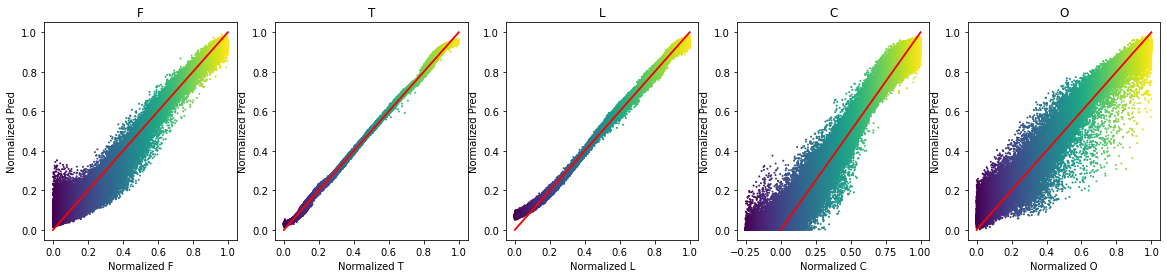

In [75]:
f, axs = plt.subplots(1,5, figsize=(20,4), sharey="col", facecolor="w")
for pdx in range(5):
    ax = axs[pdx]
    ax.scatter(train_y[:,pdx], pred_y[:,pdx], s=1, c=para[:,pdx])
    ax.plot([[0,0], [1,1]], "r")
    ax.set_title(t[pdx])
    ax.set_xlabel(f"Normalized {t[pdx]}")
    ax.set_ylabel("Normalized Pred")    

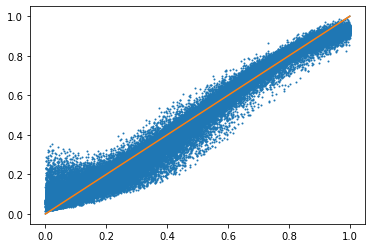

In [63]:
pdx = 0
plt.scatter(train_y[:,pdx], pred_y[:,pdx], s=1)
plt.plot([[0,0], [1,1]])

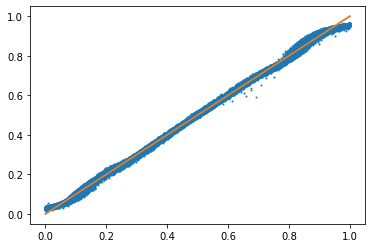

In [64]:
pdx = 1
plt.scatter(train_y[:,pdx], pred_y[:,pdx], s=1)
plt.plot([[0,0], [1,1]])